<a href="https://colab.research.google.com/github/Mifekmk/SkillTreePython-DeepLearning/blob/main/WaveNet/ch04_05_WaveNet_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# ch04.05 Wave Net

* 날짜: 2022-08-23
* 이름: 김민규

## 학습내용
    - Audio data에 대해 이해한다.
    - 머신러닝 방법으로 접근하여 문제를 해결해 본다.
    - 딥러닝 네트워크를 이용해 문제를 해결한다.
    - waveNet, yamNet 등 딥러닝 알고리즘을 적용한다.



In [2]:
import_lib = '/content/drive/MyDrive/deep_learning_frame_work/06. deep_learning/scripts_Packages/import_lib.py'

In [3]:
import tensorflow as tf
from tensorflow.keras import models, layers, utils, losses, optimizers
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## 데이터셋 - Kaggle GTZAN Dataset 
---

https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification



### **| kaggle 데이터 연동**


1. kaggle 로그인 - my account - API Create New Api Token - `kaggle.json` 파일 다운로드
2. Drive에 저장해 놓는것을 권장
3. kaggle 패키지 다운로드
```
! pip install kaggle
```
4. 권한 변경
```
! chmod 600 `드라이브 파일 경로`
```
5. `~/` 위치에 복사
```
! cp `드라이브 파일 경로` ~/.kaggle/
```

6. 데이터셋 다운로드
```
! kaggle datasets download 데이터주소
```

In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! ls -a /root

In [ ]:
! chmod 600 '/content/drive/MyDrive/deep_learning_frame_work/06. deep_learning/scripts_Packages/kaggle.json'

In [ ]:
! cp '/content/drive/MyDrive/deep_learning_frame_work/06. deep_learning/scripts_Packages/kaggle.json' ~/.kaggle/

In [ ]:
! kaggle datasets download andradaolteanu/gtzan-dataset-music-genre-classification

In [ ]:
!unzip /content/gtzan-dataset-music-genre-classification.zip

### **| EDA**

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('/content/Data/features_30_sec.csv')
print(df.shape)
df.head()

In [ ]:
# 예측해야할 클래스

class_count = df['label'].value_counts()
plt.title('Number of class')
_=sns.barplot(x=class_count.index ,y=class_count.values)
plt.xticks(rotation=45)
class_count


In [ ]:
# 음성 파일의 길이
plt.title('Audio file length')
_ = plt.hist(df['length'], log=True)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.5)

In [ ]:
# 특성 분포
print('특성 개수', len(df.columns[2:-1]))
plt.figure(figsize=(35,25))
for i,col in enumerate(df.columns[2:-1]):
    plt.subplot(6,10, i+1)
    plt.title(col)
    plt.hist(df[col])

## 머신러닝 접근 방법 (features)
---

### **| 파라미터 추가**


### **| 전처리**


In [ ]:
# label encoding ( blues, disco, ...) -> (0, 1, ...)
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
df['le_label'] = le.fit_transform(df['label'])
print(le.classes_)
df.head()

In [ ]:
x = df.drop(columns=['filename','length','label','le_label'])
y = df['le_label']
x.shape, y.shape

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, stratify=y,
                                                    random_state=0)
print('train', x_train.shape, y_train.shape)
print('test', x_test.shape, y_test.shape)

In [ ]:
# x 정규화
sc = preprocessing.StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)
x_train.shape, x_test.shape

### **| 학습 - XGBoost**

In [ ]:
! pip install xgboost -U

In [ ]:
from xgboost import XGBClassifier
xgb = XGBClassifier(n_estimators=1000)
xgb.fit(x_train, y_train)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
def show_result(model, x_test, y_test):
    y_pred = xgb.predict(x_test)
    print('Test Acc:',accuracy_score(y_test, y_pred))
    #print(classification_report(y_test, y_pred))
    confusion_matrix(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, cmap='PuBu', xticklabels=le.classes_, yticklabels=le.classes_)
show_result(xgb, x_test, y_test)

In [ ]:
from tensorflow.keras import models, layers, utils

def build_model(xgb, x_test, y_test):
    x = layers.Input(shape=(57,)) # 데이터가 주어지면 인풋의 shape는 고정
    z = layers.Dense(15,activation='relu')(x)
    z = layers.Dense(6,activation='relu')(z)
    y = layers.Dense(1)(z) # 데이터가 주어지면 아웃풋의 shape는 고정 
    # (회귀문제는 마지막 아웃풋 shape가 1, 마지막 활성함수는 사용하지 않음)
    model = models.Model(x,y, name='house_regressor')
    return model

### **| 학습 - DNN**

In [ ]:
from tensorflow.keras import models, layers, utils

def build_model(xgb, x_test, y_test):
    x = layers.Input(shape=(57))
    z = layers.Flatten()(x)
    z = layers.Dense(256, activation='relu')(z)
    z = layers.Dense(256, activation='relu')(z)
    y = layers.Dense(10, activation='softmax')(z)
    model = models.Model(x,y)
    return model

In [ ]:
model = build_model(xgb, x_test, y_test)
model.summary()

# 시각화
utils.plot_model(model, show_shapes=True)

In [ ]:
model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = 'adam')

In [ ]:
model.fit(x_train, y_train,
          epochs = 500,
          batch_size = 3)

In [ ]:
model.evaluate(x_test, y_test)

In [ ]:
y_pred = np.argmax(model.predict(x_test), axis=1)

In [ ]:
# 혼돈행렬 만들기
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# confusion_matrix는 정수값이 들어가야함
cm = confusion_matrix(y_test,y_pred)
print('Test Acc:',accuracy_score(y_test, y_pred))
ConfusionMatrixDisplay(cm).plot(cmap="Blues");

## 딥러닝 접근 방법(Audio 원 데이터)
---

In [4]:
csv_path = '/content/Data/features_30_sec.csv'
data_dir = '/content/Data/genres_original'
class_dict = {
    'blues':0,
    'classical':1,
    'country':2,
    'disco':3,
    'hiphop':4,
    'jazz':5,
    'metal':6,
    'pop':7,
    'reggae':8,
    'rock':9
}

def df_process(csv_path, data_dir, class_dict):
  df = pd.read_csv(csv_path)
  # 불량 데이터 삭제
  #np.where(df['filename']=='jazz.00054.wav')
  df = df.drop(index=[554])
  # 파일 경로 재설정
  '''
  blues.00000.wav' -> '/content/Data/genres_original/blues/blues.00000.wav'
  '''
  df['filepath'] = df.apply( lambda x:  f'{data_dir}/{x["label"]}/{x["filename"]}', axis=1 )
  # 라벨 인코딩 
  df['label'] = df['label'].map(class_dict)
  
  return list(df['filepath']), list(df['label'])

paths, labels = df_process(csv_path, data_dir, class_dict)
print(len(paths), paths[:2])
print(len(labels), labels[:2])

999 ['/content/Data/genres_original/blues/blues.00000.wav', '/content/Data/genres_original/blues/blues.00001.wav']
999 [0, 0]


In [5]:
import tensorflow_hub as hub
# 텐서플로우 허브 모델 사용
yamnet = hub.load('https://tfhub.dev/google/yamnet/1')

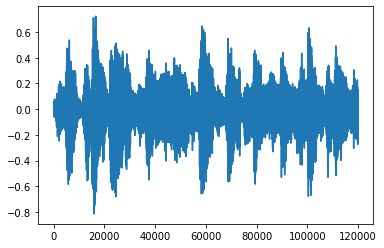

In [6]:
# 경로 -> wav 데이터 추출

def path2wav(path, label, mx_len=120000):
  # 파일 읽기
  f = tf.io.read_file(path)
  # 파일을 오디오 변환
  wav, sr = tf.audio.decode_wav(f, desired_channels=1)
  wav = tf.squeeze(wav, axis=-1)
  wav = wav[:mx_len]
  return wav, label

wav, label = path2wav(paths[0], labels[0])
plt.plot(wav)

from IPython import display
display.Audio(wav, rate=16000)

In [7]:
wav, label = path2wav(paths[0], labels[0])
scores, embeddings, log_mel_spectrogram = yamnet(wav)
embeddings.shape

TensorShape([15, 1024])

In [8]:
# 텐서플로우 텐서 슬라이스

def wav2embedding(wav, label):
  _, embedding, _ = yamnet(wav)
  return embedding, label


def ds_generator(paths, labels, batch_size=10, train=True):
  ds = tf.data.Dataset.from_tensor_slices( (paths, labels) )
  ds = ds.map(path2wav)
  ds = ds.map(wav2embedding)
  if train:
    ds = ds.shuffle(buffer_size=1000)
  ds = ds.cache().prefetch(tf.data.AUTOTUNE)
  ds = ds.batch(batch_size)
  return ds


from sklearn.model_selection import train_test_split
train_paths, test_paths, train_labels, test_labels = train_test_split(paths, labels, 
                                                                      test_size=0.1, 
                                                                      stratify=labels, 
                                                                      random_state=0)

print('train', len(train_paths), len(train_labels))
print('test', len(test_paths), len(test_labels))

train_ds = ds_generator(train_paths, train_labels)
test_ds = ds_generator(test_paths, test_labels, train=False)

train 899 899
test 100 100


In [9]:
for embeddings, labels in train_ds.take(1):
  print(embeddings.shape, labels)

(10, 15, 1024) tf.Tensor([1 5 0 6 9 8 7 1 4 4], shape=(10,), dtype=int32)


In [10]:
def create_wavenet_base(x_shape, y_shape):
  model = models.Sequential()
  model.add(layers.Input(shape=x_shape))
  
  for rate in (1,2,4,8):
    # causal, dilation
    model.add(layers.Conv1D(20, kernel_size=2, activation='relu', 
                            padding='causal',
                            dilation_rate=rate) )
  
  model.add(layers.AveragePooling1D(100, padding='same'))
  model.add(layers.Conv1D(10, 1, padding='same', activation='relu'))
  model.add(layers.AveragePooling1D(100, padding='same'))
  model.add(layers.Conv1D(10, 1, padding='same', activation='relu'))
 
  model.add(layers.Reshape( (120,) ))
  model.add(layers.Dense(10, activation='softmax'))

  model.compile(optimizer='adam', 
                loss = 'sparse_categorical_crossentropy',
                metrics=['acc'])

  return model

def create_yamnet_base(x_shape, y_shape):
  model = models.Sequential()
  model.add(layers.Input(shape=x_shape))

  model.add(layers.Dense(32, activation='relu'))
  model.add(layers.Dropout(0.5))

  model.add(layers.Reshape( (int(15*32), ) ))
  model.add(layers.Dense(10, activation='softmax'))

  model.compile(optimizer='adam', 
              loss = 'sparse_categorical_crossentropy',
              metrics=['acc'])

  return model


#x_shape = (120000, 1)
x_shape = (15, 1024)
y_shape = (10)
model = create_yamnet_base(x_shape, y_shape)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 15, 32)            32800     
                                                                 
 dropout (Dropout)           (None, 15, 32)            0         
                                                                 
 reshape (Reshape)           (None, 480)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                4810      
                                                                 
Total params: 37,610
Trainable params: 37,610
Non-trainable params: 0
_________________________________________________________________


In [11]:
model.fit(train_ds, epochs=100, validation_data=test_ds)

Epoch 1/100
90/90 [==============================] - 87s 104ms/step - loss: 1.8460 - acc: 0.3426 - val_loss: 1.1793 - val_acc: 0.5700
Epoch 2/100
90/90 [==============================] - 0s 3ms/step - loss: 1.0637 - acc: 0.6474 - val_loss: 0.8575 - val_acc: 0.6800
Epoch 3/100
90/90 [==============================] - 0s 4ms/step - loss: 0.8535 - acc: 0.7030 - val_loss: 0.7828 - val_acc: 0.7000
Epoch 4/100
90/90 [==============================] - 0s 4ms/step - loss: 0.7372 - acc: 0.7475 - val_loss: 0.7166 - val_acc: 0.8000
Epoch 5/100
90/90 [==============================] - 0s 4ms/step - loss: 0.6319 - acc: 0.7664 - val_loss: 0.7076 - val_acc: 0.8000
Epoch 6/100
90/90 [==============================] - 0s 4ms/step - loss: 0.5566 - acc: 0.8087 - val_loss: 0.7283 - val_acc: 0.8100
Epoch 7/100
90/90 [==============================] - 0s 4ms/step - loss: 0.5230 - acc: 0.8265 - val_loss: 0.6922 - val_acc: 0.8100
Epoch 8/100
90/90 [==============================] - 0s 4ms/step - loss: 0.4829 

In [ ]:
# 머신러닝 vs 딥러닝

딥러닝이 학습 잘 되려면

1. 데이터의 개수 
2. 인풋 피쳐의 dimension이 클수록 데이터 개수가 더 필요하다.


# 데이터 증강 
# 전이학습